<a href="https://colab.research.google.com/github/sandy-lee/keyword_classifier/blob/main/Keyword_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keyword Classifier

This is a notebook to show how to implement a keyword classifier for classifying keywords as part of scaling SEO processes on large, complex accounts. I'll explain things as I go with a view to showing how effective machine learning models can scale for certain problems, and also to try and illustrate some of the intricacies involved.

The dataset consists of around 10,000 keywords that I manually classified into one of around 25 categories.

Classifying this by hand was particularly tedious, but I know the data very well and it is a good illustration of how machine learning can be used to scale processes for this kind of problem.

---

To run a cell highlight it and then push SHIFT + ENTER

TO START: Run the cell below first as it clones a Github repo that contains the dataset CSV and the model used in the code below. These files are in the **/keyword_classifier** folder.

In [ ]:
!git clone https://github.com/sandy-lee/keyword_classifier.git

Cloning into 'keyword_classifier'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 67 (delta 35), reused 33 (delta 12), pack-reused 0
Unpacking objects: 100% (67/67), 19.62 MiB | 1.95 MiB/s, done.


##Code Imports

In [ ]:
import pandas as pd    #pandas for tabular data manipulation
import numpy as np     #numpy for working with large matrices of numbers
import pickle    #pickle to seralise python objests
from sklearn.utils import resample    #scikit-learn sampler for upsampling datasets
from sklearn.feature_extraction.text import TfidfVectorizer    #skikit-learn tf-idf vectoriser for encoding keywords
from sklearn.model_selection import train_test_split    #scikit-learn train/test split for creating randomised training and testing datasets
from sklearn.feature_selection import f_classif    #scikit-learn statistical test for calculating how significant model features are for training
from sklearn.feature_selection import SelectKBest    #scikit-learn library for selecting best features for model training based on f_classif
from sklearn.ensemble import GradientBoostingClassifier    #scikit-learn importthat implements a Gradient Boosted Descision Tree Classifier
from sklearn.metrics import confusion_matrix    #scikit-learn import that calculates a confusion matrix to show classifier performance
from sklearn import metrics    #scikit-learn import for generating performance metrics for classifier
import matplotlib.pyplot as plt    #pyplot for producing plots
import seaborn as sns    #seaborn library for producing nicer looking plots

## Data Import and Cleaning

In [ ]:
keywords = pd.read_csv('keyword_classifier/keywords_categories.csv')    #import CSV into a dataframe

In [ ]:
keywords.head(20)    #first 20 row of the dataset; it consists of 2 columns with keyword and its category in the next column

,keyword,category
0,writing fonts,font type
1,word fonts,font type
2,windows fonts,font type
3,wedding fonts,font type
4,wedding font,font type
5,website fonts,font type
6,webfonts,font type
7,webfont,font type
8,web safe fonts,font type
9,web friendly fonts,font type


In [ ]:
keywords.pivot_table('keyword', index = 'category', aggfunc='count').sort_values(by='keyword', ascending=False)    #this is a pivot table of all categories with the number of keywords

,keyword
category,
monotype,2188
font technology,1740
fonts by vertical,936
font,813
html5,703
digital advertising,586
emoji,547
font type,488
mobile advertising,457


Data leakage is where a model has access to information it shouldn't have access to before making a prediction. So for example in this case it is where the keyword and the category are the same (e.g. the keyword [font] belonging to the FONT category); all instances of data leakage should be removed as it can negatively impact the model performance.

In [ ]:
data_leakage = [row for row in zip(keywords.keyword,keywords.category) if row[0] == row[1]]
data_leakage_df = pd.DataFrame(columns = ['keyword', 'category'], data=data_leakage)

In [ ]:
keywords = keywords[~(keywords.keyword + keywords.category).isin(data_leakage_df.keyword + data_leakage_df.category)]

Any category that has less than 100 keywords will negatively impact model performance as there isn't enough keywords for the model to be able to make any reasonable interpretations and will appear as noise. These smaller categorys are rolled into a larger 'miscellaneous' category.

In [ ]:
item_counts = keywords.category.value_counts()
for index,item in enumerate(keywords.category):
    if item_counts.loc[item]<100:
        keywords.category.iloc[index]='misc'

<ipython-input-8-4aef160dab7a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords.category.iloc[index]='misc'


In [ ]:
item_counts = keywords.category.value_counts()
item_counts

monotype               2185
font technology        1739
fonts by vertical       936
font                    813
html5                   702
digital advertising     585
emoji                   546
font type               488
mobile advertising      456
fonts for               428
misc                    381
sticker packs           280
fontshop                165
flash alternatives      142
brand emoji             118
font style              112
Name: category, dtype: int64

Below is a plot showing the number of keywords per category with the new categories. There are issues with a large class imbalance which will impact model performance. We need to make sure there is the same number of instances in each class so the model won't become skewed.

In [ ]:
classes = keywords.pivot_table('keyword', index = 'category', aggfunc='count').sort_values(by='keyword', ascending=False)

<Axes: xlabel='category'>

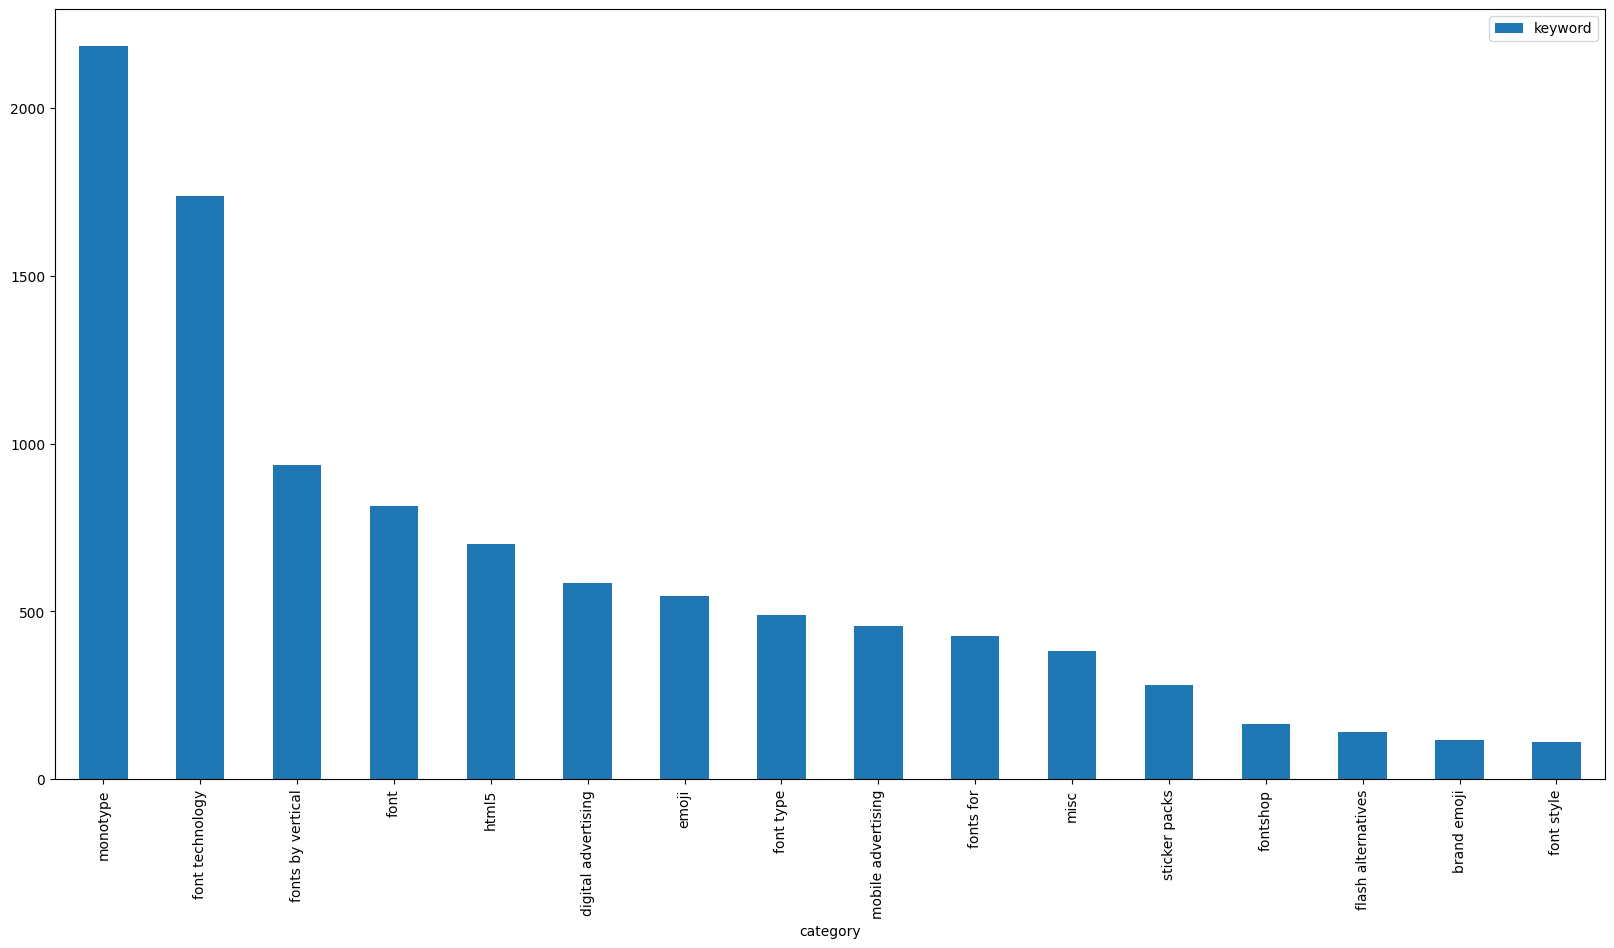

In [ ]:
classes.plot.bar(figsize=(20,10))

In order to deal with class , we need to randomly upsample the other classes so they have the same number of instances as the majority class (in the case of the MONOTYPE class which has 2,185 instances). The sampling is random with replacement and will eliminate class imbalance without disrupting the variance in the dataset too much and producing a lot more valid data to work with.

In [ ]:
def upsample(class_list, dataframe):
    frames = {}
    frames_upsampled = {}
    for index,item in enumerate(class_list):
        frames[item]= dataframe[dataframe.category == class_list[index]]
    for index,item in enumerate(class_list):
        frames_upsampled[item] = resample(frames[item], replace=True,
        n_samples = 2185, random_state = 42)
    upsampled_df = pd.concat(frames_upsampled.values(), ignore_index=True)
    return upsampled_df

In [ ]:
upsampled = upsample(item_counts.index.tolist(), keywords)

In [ ]:
classes_upsampled = upsampled.pivot_table('keyword', index = 'category', aggfunc='count').sort_values(by='keyword', ascending=False)

The plot below shows the number of instances per class and as we can see they are now all the same with the dataset having been tripled.

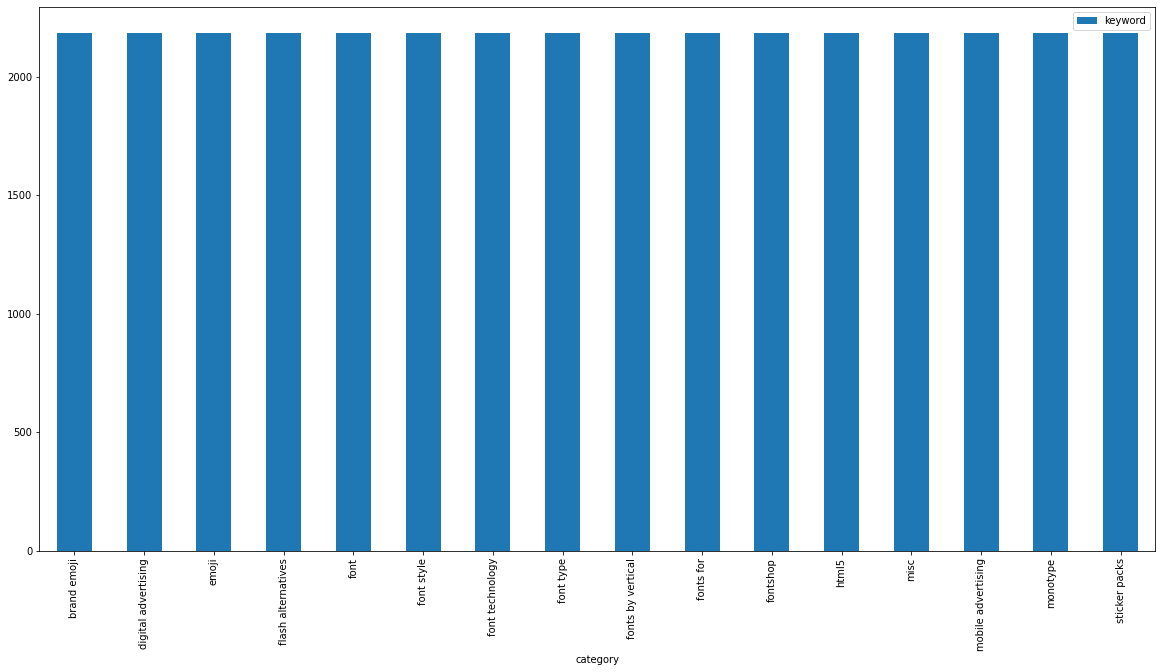

In [ ]:
classes_upsampled.plot.bar(figsize=(20,10))

The upsampled dataset is now split into two with `X=keywords` and `y=classes`. These now need to randomly be split into three separate datasets. Seventy percent of the data is the **training** dataset that will be used to train the classifier. Fifteen percent of the dataset will be **validation** dataset not used in training but will be used to optimise the dataset training to produce better results. The final fifteen percent is used as a **test** dataset and is not used for any kind of training or optimisation and is used to assess the performance of the classifier with unseen data. More information [here](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7).

In [ ]:
X = upsampled.keyword
y = upsampled.category
X_train, X_remainder, y_train, y_remainder = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_remainder, y_remainder, test_size = 0.5, random_state = 42)

Machine learning models can only work with numbers and so before the data can be used for training it needs to be encoded in a way that captures features with a variance that is useful for model training. There are lots of ways to do this, but for this type of problem, one of the most effective ways of doing this is to use **Term Frequency-Inverse Document Frequency**(TF-IDF). More information [here](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a).

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), dtype= 'int32', strip_accents= 'unicode', decode_error='replace', analyzer= 'word', min_df= 2)

In [ ]:
x_train = vectorizer.fit_transform(X_train);

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:2032: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning,


In [ ]:
x_test = vectorizer.transform(X_test)

Machine models work better when redundant data is removed. Redundant meaning they don't contribute anything to model training. With `f_classif` we use an [ANOVA](https://https://en.wikipedia.org/wiki/Analysis_of_variance) test to highlight features that have lower variance and greater distance between means and therefore greater discrimination between classes. More information [here](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w.)

In [ ]:
selector = SelectKBest(f_classif, k=min(20000, x_train.shape[1]))

In [ ]:
selector.fit(x_train,y_train)

SelectKBest(k=8518)

In [ ]:
x_train = selector.transform(x_train).astype('float32')
x_test = selector.transform(x_test).astype('float32')

In [ ]:
x_val = vectorizer.transform(X_val)
x_val = selector.transform(x_val).astype('float32')

## Building the Model ##

I've cheated a little bit here. A typical data science workflow would be to choose a model as a benchmark and then try different models to see which one would give the best performance. You would then work to optimise the model further so it works better. I've short-circuited this process as I've picked a model I know would work well for this type of problem. It is a [Gradient Boosted Decision Tree](https://https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4), although I did do some optimisations to improve its performance. The whole model training and optimisation step is a bit of a faff and takes a couple of hours so I've left this out and saved a finalised model for you to play with. The step below imports the final serialised pre-trained model.

In [ ]:
clf  = pickle.load(open('keyword_classifier/gbdt_colab.sav', 'rb'))    #import pre-trained model

## Measuring the Model Performance ##

We can test the performance of this model on the **validation** dataset as this is completely new data. As we can the model performs well and has a **accuracy** of around 93-94%. **Accuracy** is a measure of how correct the model is at classifying keywords i.e. here it is correct 93-94% of the time.

In [ ]:
clf.score(x_val,y_val)

0.9364988558352403

With multi-class classification problems, **accuracy** is not always a good measure of performance (although we should be okay here as there is the same number of instances in each class). It is best practice to dig deeper and see how the model discriminates against different classes in its predictions. More info [here](https://https://en.wikipedia.org/wiki/Confusion_matrix).

In [ ]:
y_val_pred = clf.predict(x_val)

In [ ]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

In [ ]:
classes = clf.classes_

In [ ]:
conf_matrix_df = pd.DataFrame(conf_matrix, index = classes, columns = classes)

The confusion matrix shows the performance of the classifier for each class in the **validation** dataset. As can be seen below the classifier struggles to discriminate FONT TECHNOLOGY keywords from FONT keywords. Also, FONT and FONT TYPE keywords from FONT STYLE keywords. This could mean there is very little difference between these keywords making them hard to discriminate or they have been mislabelled by a human. I remember when I labelled this dataset by hand it was very hard to do as the keywords were very similar and it was very subjective. If this were 'real' we would need to look into these labels again and either make more prescriptive features (such as new categories) or move the decision boundary between classes.

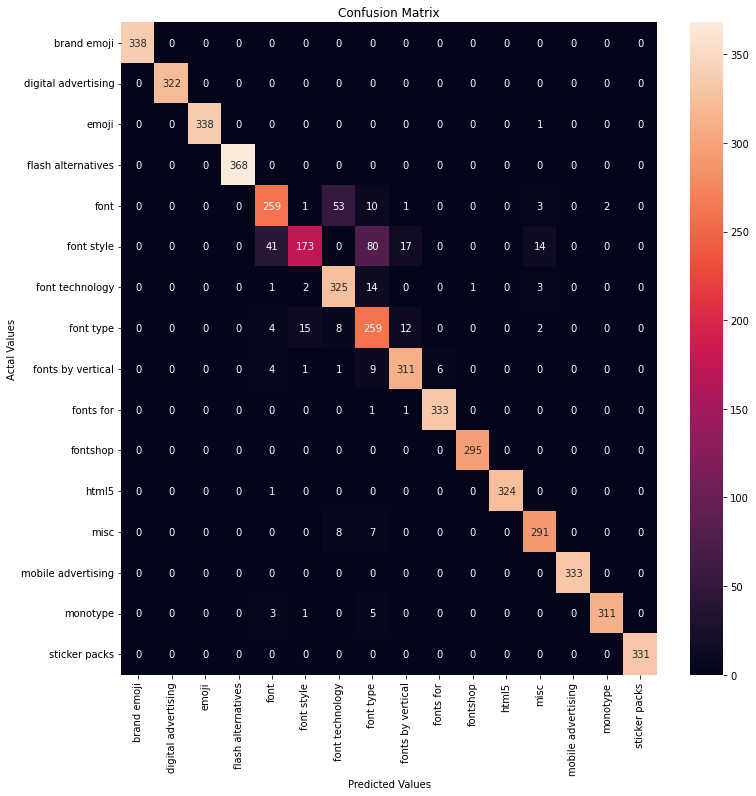

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

There are better metrics when assessing multi-class classification problems. These are **precision**, **recall** and the **F1 score**. For more information on this see [here](https://https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9). The score we are most interested in there is the **F1 score** A it gives a more balanced view of the classifier's ability to discriminate classes. The **F1-score** is between 0 - 1 with 0 being bad and one being a perfect classifier. The **F1-score** on the validation dataset is **0.94** which is very good. We could try other algorithms to see if we get better performance but I'd be happy with an **F1-score* of 0.95 overall.

In [ ]:
print(metrics.classification_report(y_val, y_val_pred))

                     precision    recall  f1-score   support

        brand emoji       1.00      1.00      1.00       338
digital advertising       1.00      1.00      1.00       322
              emoji       1.00      1.00      1.00       339
 flash alternatives       1.00      1.00      1.00       368
               font       0.83      0.79      0.81       329
         font style       0.90      0.53      0.67       325
    font technology       0.82      0.94      0.88       346
          font type       0.67      0.86      0.76       300
  fonts by vertical       0.91      0.94      0.92       332
          fonts for       0.98      0.99      0.99       335
           fontshop       1.00      1.00      1.00       295
              html5       1.00      1.00      1.00       325
               misc       0.93      0.95      0.94       306
 mobile advertising       1.00      1.00      1.00       333
           monotype       0.99      0.97      0.98       320
      sticker packs    

## Try it Yourself ##

Run the cell below to try the model yourself. You can put a keyword into the input cell and the model will output a prediction of the class it thinks the keyword belongs to. One thing to note is that machine learning models are snapshots in time and so this classifier will work very well on the Monotype website of 2015 (see Wayback Machine link [here](https://https://web.archive.org/web/20151118070642/http://www.monotype.com)), but it won't generalise well to the Monotype website of 2022 as the data now would be completely different.

To get the best out of this, look at the 2015 Monotype website and look at website section names and see if the classifier predicts something that makes sense. Examples of good queries to try are **[fonts for advertising]**, **[comic sans]**, **[memory efficient fonts]**.

In [ ]:
query = [input()]
query_vec = vectorizer.transform(query)
query_vec_op = selector.transform(query_vec).astype('float32')
print()
prediction = clf.predict(query_vec_op)[0]
print(str.upper(prediction))

memory efficient fonts

FONT TECHNOLOGY


## Next Steps ##

If we were doing this for real, the next steps would be to containerize the model and deploy it to an end-point, this is where we enter the work of [ML-OPs](https://https://en.wikipedia.org/wiki/MLOps). This can be complicated as the model performance needs to be monitored to ensure the model doesn't become stale and a new model is produced periodically with updated data.

A lower barrier of entry exists with [Google Cloud](https://https://cloud.google.com/) and it is possible to use their [AutoML](https://cloud.google.com/automl) and/or [Big Query ML](https://cloud.google.com/bigquery-ml/docs) products to produce models in a semi-automated way and deploy them to an endpoint. The Big Query ML product would be a good starting point.

It is worth noting the model here was produced 'by hand' and with AutoML products, you won't always get the best results and you should still look for machine learning expertise even with these products. But it is a starting point.